# Day 08. Exercise 03
# Overfitting

## 0. Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from joblib import dump, load

## 1. Preprocessing

1. Read the file `dayofweek.csv` to a dataframe.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test`.
3. Using, for example, `value_counts()` to check if the distribution of classes is similar in train and test.
4. Use the additional parameter `stratify=` and check the distribution again, now it should be more or less similar in both datasets.

In [2]:
df = pd.read_csv('../data/dayofweek.csv')
df.head()

,numTrials,hour,dayofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,...,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,-0.788667,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.756764,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.724861,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.692958,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.661055,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('dayofweek', axis=1), 
                                                    df['dayofweek'], 
                                                    test_size=0.2, 
                                                    random_state=21)

In [5]:
print("Распределение классов в обучающем наборе:")
print(y_train.value_counts())

print("Распределение классов в тестовом наборе:")
print(y_test.value_counts())

Распределение классов в обучающем наборе:
dayofweek
3    313
6    287
1    222
5    216
2    125
0    105
4     80
Name: count, dtype: int64
Распределение классов в тестовом наборе:
dayofweek
3    83
6    69
5    55
1    52
0    31
4    24
2    24
Name: count, dtype: int64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('dayofweek', axis=1), 
                                                                            df['dayofweek'], 
                                                                            test_size=0.2, 
                                                                            random_state=21, 
                                                                            stratify=df['dayofweek'])

print("Распределение классов в обучающем наборе с stratify:")
print(y_train.value_counts())

print("Распределение классов в тестовом наборе с stratify:")
print(y_test.value_counts())

Распределение классов в обучающем наборе с stratify:
dayofweek
3    316
6    285
1    219
5    217
2    119
0    109
4     83
Name: count, dtype: int64
Распределение классов в тестовом наборе с stratify:
dayofweek
3    80
6    71
1    55
5    54
2    30
0    27
4    21
Name: count, dtype: int64


## 2. Baseline models

1. Train exactly the same baseline models from the previous exercise and calculate the accuracies using the test dataset with stratification.
2. Did all the models show the similar values of the metric? Which one has the largest difference comparing the current exercise and the previous? Put the answer to the markdown cell in the end of the section.

### a. Logreg

In [10]:
lr = LogisticRegression(random_state=21, fit_intercept=False)
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)

accuracy_score(y_test, y_lr)

0.6331360946745562

### b. SVM

In [11]:
svc = SVC(kernel='linear', probability=True, random_state=21)
svc.fit(X_train, y_train)

y_svc = svc.predict(X_test)

accuracy_score(y_test, y_svc)

0.7159763313609467

### c. Decision tree

In [14]:
dtree = DecisionTreeClassifier(max_depth=9, random_state=21)
dtree.fit(X_train, y_train)

y_dtree = dtree.predict(X_test)

accuracy_score(y_test, y_dtree)

0.7071005917159763

### d. Random forest

In [15]:
rf = RandomForestClassifier(n_estimators=100,
                             max_depth=25,
                             random_state=21)
rf.fit(X_train, y_train)

accuracy_score(y_test, rf.predict(X_test))

0.9289940828402367

best RandomForest

## 3. Crossvalidation

We could play with parameters of the model trying to achive a better accuracy on the test dataset, but it is a bad practice. It leads us again to overfitting. Test dataset is only for checking quality of a final model.

But there is another way of solving the problem – crossvalidation. It does not use test dataset, but creates one more split of train dataset. Again, there are different ways of doing it, but the common thing is that there is a validation dataset that is used for hyperparameters optimization.

1. Using `cross_val_score` with `cv=10` calculate the mean accuracy and standard deviation for every model that you used before (logreg with `solver='liblinear'`, SVC, decision tree, random forest).

### a. Logreg

In [17]:
lr_cv = LogisticRegression(solver='liblinear')
scores_lr_cv = cross_val_score(lr_cv, X_train, y_train, cv=10)
print("Средняя точность LR_cv:", np.mean(scores_lr_cv))
print("Стандартное отклонение LR_cv:", np.std(scores_lr_cv))

Средняя точность LR_cv: 0.5927363184079601
Стандартное отклонение LR_cv: 0.019852534178785148


### b. SVM

In [18]:
svc_cv = SVC()
scores_svc_cv = cross_val_score(svc_cv, X_train, y_train, cv=10)
print("Средняя точность SVC_cv:", np.mean(scores_svc_cv))
print("Стандартное отклонение SVC_cv:", np.std(scores_svc_cv))

Средняя точность SVC_cv: 0.7833333333333334
Стандартное отклонение SVC_cv: 0.025446087664058065


### c. Decision tree

In [19]:
dt_cv = DecisionTreeClassifier()
scores_dt_cv = cross_val_score(dt_cv, X_train, y_train, cv=10)
print("Средняя точность DT_cv:", np.mean(scores_dt_cv))
print("Стандартное отклонение DT_cv:", np.std(scores_dt_cv))

Средняя точность DT_cv: 0.8797954671089
Стандартное отклонение DT_cv: 0.021328720766270032


### d. Random forest

In [20]:
rf_cv = RandomForestClassifier(n_estimators=40)
scores_rf_cv = cross_val_score(rf_cv, X_train, y_train, cv=10)
print("Средняя точность RF_cv:", np.mean(scores_rf_cv))
print("Стандартное отклонение RF_cv:", np.std(scores_rf_cv))

Средняя точность RF_cv: 0.9094637921503592
Стандартное отклонение RF_cv: 0.022830397380626668


## 4. Optimization

1. Choose the best model and play a little bit with the parameters on cross-validation, find a good enough parameter or a combination of the parameters.
2. Calculate the accuracy for the final model on the test dataset.
3. Draw a plot that displays the top-10 most  important features for that model.
4. Save the model using `joblib`.
5. Load the model, make predictions for the test dataset and calculate the accuracy.

In [21]:
param_grid = {'n_estimators': [100, 200, 300, 400, 500]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=21), param_grid, cv=10, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'n_estimators': 200}


In [22]:
best_rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], random_state=21)
best_rf.fit(X_train, y_train)

y_pred_test = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
print("Точность на тестовом наборе:", accuracy)

Точность на тестовом наборе: 0.9378698224852071


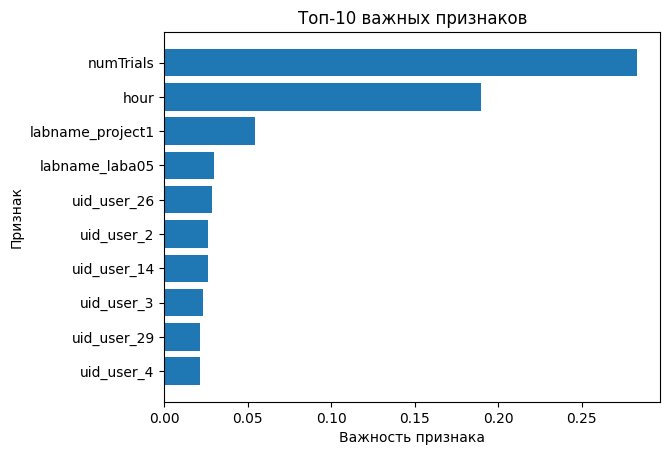

In [23]:
def plot_feature_importance(importance, feature_names, top_n=10):
    importance_abs = np.abs(importance)
    
    sorted_idx = np.argsort(importance_abs)
    
    top_n_idx = sorted_idx[-top_n:]
    
    plt.barh(feature_names[top_n_idx], importance_abs[top_n_idx])
    plt.xlabel('Важность признака')
    plt.ylabel('Признак')
    plt.title('Топ-10 важных признаков')
    plt.show()

importance = best_rf.feature_importances_

plot_feature_importance(importance, X_train.columns, top_n=10)

In [25]:
dump(best_rf, 'best_rf_model.joblib')

['best_rf_model.joblib']

In [28]:
loaded_rf = load('best_rf_model.joblib')

y_pred_test_loaded = loaded_rf.predict(X_test)

accuracy_loaded = accuracy_score(y_test, y_pred_test_loaded)
print("Точность на тестовом наборе (загруженная модель):", accuracy_loaded)

Точность на тестовом наборе (загруженная модель): 0.9378698224852071
